In [10]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.ops import unary_union
import os

# --- 1. Paths (ahora usando recursos locales) ---
# Nota: Los archivos Sentinel originales (.jp2) no están disponibles localmente.
# Este notebook ahora trabaja con los archivos ya procesados en la carpeta data/
# Si necesitas ejecutar el recorte original, deberás obtener los archivos .jp2

# Verificar si existen archivos .jp2 locales (opcional)
data_dir = 'data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Intentar usar archivos .jp2 si existen, sino usar los .tif ya procesados
S2_b04_jp2 = os.path.join(data_dir, 'SENTINEL-2_B04_10m.jp2')
S2_b08_jp2 = os.path.join(data_dir, 'SENTINEL-2_B08_10m.jp2')

if os.path.exists(S2_b04_jp2) and os.path.exists(S2_b08_jp2):
    S2_b04 = S2_b04_jp2
    S2_b08 = S2_b08_jp2
    # Usar radios_BA.shp que está completo (tiene .shp, .shx, .dbf, .prj)
    geometrias = os.path.join(data_dir, 'radios_BA.shp')
    
    # --- 2. Leer shapefile ---
    geometrias_gdf = gpd.read_file(geometrias)
    
    print("CRS de geometrías:", geometrias_gdf.crs)
    
    # --- 3. Reproyectar a CRS de Sentinel (si es necesario) ---
    with rasterio.open(S2_b04) as src:
        raster_crs = src.crs
    
    if geometrias_gdf.crs != raster_crs:
        print(f"Reproyectando de {geometrias_gdf.crs} → {raster_crs}")
        geometrias_gdf = geometrias_gdf.to_crs(raster_crs)
    
    # --- 4. Crear geometría combinada y buffer ---
    union = unary_union(geometrias_gdf.geometry)
    
    # Buffer de 1000 metros (solo si CRS está en metros)
    margen_metros = 1000
    union_buffer = union.buffer(margen_metros)
    
    # Corregir posibles geometrías inválidas
    union_buffer = gpd.GeoSeries([union_buffer]).buffer(0).iloc[0]
    
    # --- 5. Función de recorte robusta ---
    def recortar_raster(ruta_entrada, geometria, ruta_salida):
        with rasterio.open(ruta_entrada) as src:
            # Recortar (crop)
            out_image, out_transform = mask(src, [geometria], crop=True)
            out_meta = src.meta.copy()
            out_meta.update({
                "driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform
            })
            with rasterio.open(ruta_salida, "w", **out_meta) as dest:
                dest.write(out_image)
    
    # --- 6. Aplicar recorte ---
    recortar_raster(S2_b04, union_buffer, os.path.join(data_dir, 'S2_B04_CABA_buffer.tif'))
    recortar_raster(S2_b08, union_buffer, os.path.join(data_dir, 'S2_B08_CABA_buffer.tif'))
    
    print("✅ Recorte completado sin errores.")
else:
    print("⚠️ Los archivos Sentinel-2 originales (.jp2) no están disponibles.")
    print("Los archivos ya procesados están disponibles en la carpeta 'data/':")
    print(f"  - {os.path.join(data_dir, 'S2_B04_CABA_buffer.tif')}")
    print(f"  - {os.path.join(data_dir, 'S2_B08_CABA_buffer.tif')}")
    print(f"  - {os.path.join(data_dir, 'radios_BA.shp')}")
    print("\nPuedes continuar con la segunda celda para visualizar el NDVI.")


⚠️ Los archivos Sentinel-2 originales (.jp2) no están disponibles.
Los archivos ya procesados están disponibles en la carpeta 'data/':
  - data\S2_B04_CABA_buffer.tif
  - data\S2_B08_CABA_buffer.tif
  - data\radios_BA.shp

Puedes continuar con la segunda celda para visualizar el NDVI.


C:\Users\tomas\AppData\Local\Temp\ipykernel_4692\3533099720.py:22: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where((b8 + b4) == 0, np.nan, (b8 - b4) / (b8 + b4))


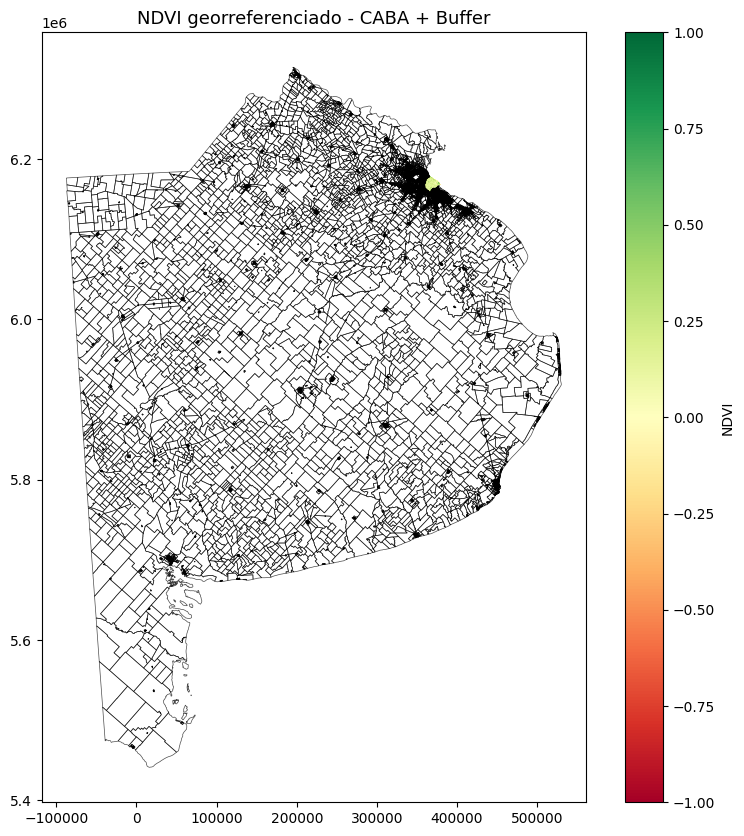

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import plotting_extent
import geopandas as gpd
import os

# Paths (usando recursos locales)
data_dir = 'data'
S2_B04_CABA_buffer = os.path.join(data_dir, 'S2_B04_CABA_buffer.tif')
S2_B08_CABA_buffer = os.path.join(data_dir, 'S2_B08_CABA_buffer.tif')
# Usar radios_BA.shp que está completo (tiene .shp, .shx, .dbf, .prj)
geometrias = os.path.join(data_dir, 'radios_BA.shp')

# Leer shapefile
geometrias_gdf = gpd.read_file(geometrias)

# Calcular NDVI con georreferencia
with rasterio.open(S2_B04_CABA_buffer) as red_src, rasterio.open(S2_B08_CABA_buffer) as nir_src:
    b4 = red_src.read(1).astype('float32')
    b8 = nir_src.read(1).astype('float32')
    ndvi = np.where((b8 + b4) == 0, np.nan, (b8 - b4) / (b8 + b4))
    extent = plotting_extent(red_src)
    raster_crs = red_src.crs

# Reproyectar geometrías si es necesario
if geometrias_gdf.crs != raster_crs:
    geometrias_gdf = geometrias_gdf.to_crs(raster_crs)

# Mostrar NDVI georreferenciado
fig, ax = plt.subplots(figsize=(10,10))
ndvi_plot = ax.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1, extent=extent)
geometrias_gdf.boundary.plot(ax=ax, color='black', linewidth=0.5, alpha=0.7)
plt.colorbar(ndvi_plot, ax=ax, label="NDVI")
ax.set_title("NDVI georreferenciado - CABA + Buffer", fontsize=13)
plt.show()